<a href="https://colab.research.google.com/github/DanieleBaiocco/IPCV_assignment1/blob/main/assignment_module_one.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Product Recognition of Food Products**

## Image Processing and Computer Vision - Assignment Module \#1


Contacts:

- Prof. Giuseppe Lisanti -> giuseppe.lisanti@unibo.it
- Prof. Samuele Salti -> samuele.salti@unibo.it
- Alex Costanzino -> alex.costanzino@unibo.it
- Francesco Ballerini -> francesco.ballerini4@unibo.it


Computer vision-based object detection techniques can be applied in super market settings to build a system that can identify products on store shelves.
An example of how this system could be used would be to assist visually impaired customers or automate common store management tasks like detecting low-stock or misplaced products, given an image of a shelf in a store.

## Task
Develop a computer vision system that, given a reference image for each product, is able to identify such product from one picture of a store shelf.

<figure>
<a href="https://imgbb.com/">
  <center>
  <img src="https://i.ibb.co/TwkMWnH/Screenshot-2024-04-04-at-14-54-51.png" alt="Screenshot-2024-04-04-at-14-54-51" border="0" width="300" />
</a>
</figure>

For each type of product displayed in the
shelf the system should report:
1. Number of instances;
1. Dimension of each instance (width and height in pixel of the bounding box that enclose them);
1. Position in the image reference system of each instance (center of the bounding box that enclose them).

#### Example of expected output
```
Product 0 - 2 instance found:
  Instance 1 {position: (256, 328), width: 57px, height: 80px}
  Instance 2 {position: (311, 328), width: 57px, height: 80px}
Product 1 – 1 instance found:
.
.
.
```

### Track A - Single Instance Detection
Develop an object detection system to identify single instance of products given one reference image for each item and a scene image.

The system should be able to correctly identify all the product in the shelves
image.

### Track B - Multiple Instances Detection
In addition to what achieved at step A, the system should also be able to detect multiple instances of the same product.

## Data
Two folders of images are provided:
* **Models**: contains one reference image for each product that the system should be able to identify.
* **Scenes**: contains different shelve pictures to test the developed algorithm in different scenarios. The images contained in this folder are corrupted by noise.

#### Track A - Single Instance Detection
* **Models**: {ref1.png to ref14.png}.
* **Scenes**: {scene1.png to scene5.png}.

#### Track B - Multiple Instances Detection
* **Models**: {ref15.png to ref27.png}.
* **Scenes**: {scene6.png to scene12.png}.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

!cp -r /content/drive/MyDrive/AssignmentsIPCV/dataset.zip ./
!unzip dataset.zip

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Archive:  dataset.zip
replace __MACOSX/._dataset? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

## Evaluation criteria
1. **Procedural correctness**. There are several ways to solve the assignment. Design your own sound approach and justify every decision you make;

2. **Clarity and conciseness**. Present your work in a readable way: format your code and comment every important step;

3. **Correctness of results**. Try to solve as many instances as possible. You should be able to solve all the instances of the assignment, however, a thoroughly justified and sound procedure with a lower number of solved instances will be valued **more** than a poorly designed approach.

In [5]:
import cv2
import matplotlib.pyplot as plt
import os
import numpy as np

TRACK A - SINGLE INSTANCE DETECTION

In [6]:
def create_list_of_paths(directory):
    image_files = os.listdir(directory)
    image_files.sort(key=lambda x: int(''.join(filter(str.isdigit, x))))
    image_files = [os.path.join(directory, image_file) for image_file in image_files]
    return image_files

In [7]:
images_directory = '/content/dataset'
reference_directory = os.path.join(images_directory, 'models')
scene_directory =  os.path.join(images_directory, 'scenes')
reference_files = create_list_of_paths(reference_directory)
scene_files = create_list_of_paths(scene_directory)

In [23]:
class Image:
    def __init__(self, path, is_colored, preprocess):
        self.image = None
        image = cv2.imread(path, is_colored)
        if preprocess:
          self._preprocess_image(image)
        else:
          self.image = image
        self.label = path.split("/")[-1]

    def _preprocess_image(self, image):
        image = cv2.medianBlur(image, ksize = 5)
        self.image = cv2.fastNlMeansDenoisingColored(image, None, h=20,hColor=20,templateWindowSize =5,searchWindowSize =27)

In [9]:
def create_subset_of_images(list_of_paths, start, end, is_colored, preprocess = False):
  assert start < end and start >= 0 and end <= len(list_of_paths)
  subset_of_paths = list_of_paths[start:end]
  subset_of_images = []
  for idx, path in enumerate(subset_of_paths):
    image = Image(path, is_colored, preprocess)
    if idx ==1:
          m = cv2.cvtColor(image.image, cv2.COLOR_BGR2RGB)
          plt.imshow(m)
          plt.show()
    subset_of_images.append(image)
  return subset_of_images

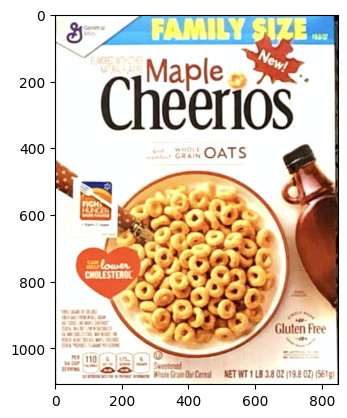

In [12]:
track_A_reference_images = create_subset_of_images(reference_files, start=0, end=14, is_colored =1)

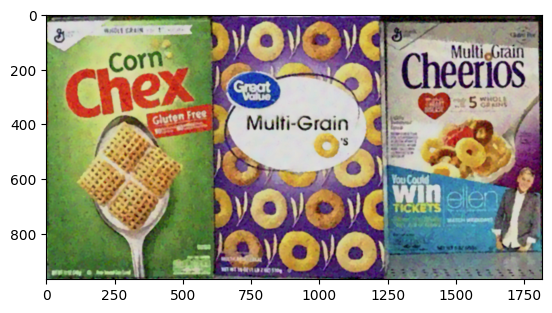

In [19]:
track_A_scene_images = create_subset_of_images(scene_files, start=0, end=5, is_colored=1, preprocess =True)

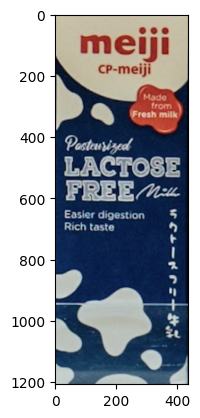

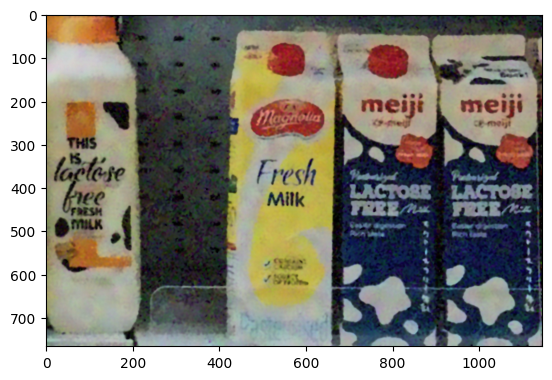

In [24]:
track_B_reference_images = create_subset_of_images(reference_files, start=14, end=27, is_colored=1)
track_B_scene_images = create_subset_of_images(scene_files,  start=5, end=12, is_colored=1, preprocess=True)

CAPISCI come funziona questa cosa del sift detector che mi sa lavora solo su grayscale images, pero' magari posso fare shift detector per ogni channel (adesso vediamo se e' possibile). Per adesso tengo tutto a grayscale

In [26]:
def compute_flann_2NN_matching(flann_index_kdtree, trees, checks, k):
  index_params = dict(algorithm = flann_index_kdtree, trees = trees)
  search_params = dict(checks = checks)
  flann = cv2.FlannBasedMatcher(index_params, search_params)
  def compute_flan(des_reference, des_scene):
      matches =  flann.knnMatch(des_reference,des_scene,k=k)
      good = []
      for m,n in matches:
          if m.distance < 0.7*n.distance:
              good.append(m)
      return good
  return compute_flan

In [27]:
def compute_homography(homography_method, ransacReprojThreshold):
  def find_homography(matches, kp_reference, kp_scene):
    src_pts = np.float32([ kp_reference[m.queryIdx].pt for m in matches ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp_scene[m.trainIdx].pt for m in matches ]).reshape(-1,1,2)
    M, mask = cv2.findHomography(src_pts, dst_pts, homography_method, ransacReprojThreshold)
    matchesMask = mask.ravel().tolist()
    return M, matchesMask
    ## POTREI FERMARMI QUI, ritornare la M con la mask e poi TUTTE INSIEME SULLA STESSA TARGET IMAGE outputtare le bounding boxes per ogni
    ## item (solo nel caso in cui ho un matchovviamente)
  return find_homography


In [28]:
lambda_matcher = compute_flann_2NN_matching(flann_index_kdtree = 1, trees = 15, checks = 100, k =2)

In [29]:
def compute_box(reference_image, scene_image, M):
  h,w,_ = reference_image.shape
  pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
  dst = cv2.perspectiveTransform(pts,M)
  return dst


In [30]:
lambda_homography = compute_homography(homography_method = cv2.RANSAC, ransacReprojThreshold = 5.0)

In [31]:
def sift_instance_detection(reference, scene, perform_matcher, min_match_count, compute_homography):
  reference_image, scene_image, reference_label = reference.image, scene.image, reference.label
  sift = cv2.xfeatures2d.SIFT_create()
  kp_reference = sift.detect(reference_image)
  kp_scene = sift.detect(scene_image)
  kp_reference, des_reference = sift.compute(reference_image, kp_reference)
  kp_scene, des_scene = sift.compute(scene_image, kp_scene)
  matches = perform_matcher(des_reference,des_scene)
  print(len(matches))
  if len(matches)<=min_match_count:
    return None
  M, mask = compute_homography(matches, kp_reference, kp_scene)
  dst = compute_box(reference_image, scene_image, M)
  return dst, len(matches)

# TODO
1. deblurra tutte le *scene images* con qualcosa: o usi un bel bilateral filter, o usi un median filter, o fai una combo di filters. Se noti punti bianchi puoi prima fare median filter per rimuoverli e poi bilateral/gaussian filter (penso bilateral e' comunque la way). Controlla pure non-local means filter che  puo' essere interessante
2. per matchare piu' di un elemento in una scena, segui il procedimento visto fin'ora fino al punto in cui hai M. Questa permettera' di fare un warp della reference image nella *scene image*. A questo punto, posso slidare sulla *scene image* utilizzando la *reference image warpata*. Posso fare in due modi in verita': o applico un matching usando similarity functions, OPPURE applico una shape matching (quindi facendo passare l'immagine warpata in un algoritmo di edge detection, calcolando poi per alcuni punti il gradiente).

3. DUBBI: non so se e' possibile runnare un salient point matching basato su differenti colori rgb per poi farne la media insomma ma mi sembra assurdo.
Non so se ci sono benefici nel far prima un edge detection, prima del salient point matching (ma dubito non ha molto senso).
Non so se ha senso in nessun momento fare edge detection in verita'.

In [32]:
def draw_bounding_box(bounding_box, reference_label, img_bounding_boxes):
    random_color = np.random.randint(0, 256, size=(3,)).tolist()
    label_shift = 60
    img_bounding_boxes = cv2.polylines(img_bounding_boxes,[np.int32(bounding_box)],True,random_color,10, cv2.LINE_AA)
    label_position = (int(bounding_box[0][0][0]) + label_shift, int(bounding_box[0][0][1]) + label_shift)
    cv2.putText(img_bounding_boxes, reference_label, label_position, cv2.FONT_HERSHEY_SIMPLEX, fontScale=2.0, color= (0,0,0), thickness =3)
    return img_bounding_boxes

In [33]:
def compute_box_description(box_coordinates):
    x_values = [coord[0][0] for coord in box_coordinates]
    y_values = [coord[0][1] for coord in box_coordinates]
    x_sum = sum(x_values)
    y_sum = sum(y_values)
    num_coords = len(box_coordinates)
    center_x = round(x_sum / num_coords,3)
    center_y = round(y_sum / num_coords,3)
    width = round(max(x_values) - min(x_values),3)
    height = round(max(y_values) - min(y_values),3)
    return (center_x, center_y), width, height

In [34]:
import pandas as pd
def find_items_in_scene_image(min_match_count, reference_images, scene_image, lambda_matcher, lambda_homography):
  df = []
  for reference_image in reference_images:
    result = sift_instance_detection(reference_image, scene_image, lambda_matcher, min_match_count, lambda_homography)
    if result is not None:
      dst, num_matches = result
      center, width, height =  compute_box_description(dst)
      df.append([reference_image.label, dst, center, width, height, num_matches])
  return pd.DataFrame(df, columns = ['reference_label', 'dst', 'center', 'width', 'height', 'num_matches'])

In [35]:
def calculate_iou(box1, box2):
    # Extract coordinates from the list of points
    box1_coords = [point[0] for point in box1]
    box2_coords = [point[0] for point in box2]

    # Get coordinates of the intersection rectangle
    x1 = max(box1_coords[0][0], box2_coords[0][0])
    y1 = max(box1_coords[0][1], box2_coords[0][1])
    x2 = min(box1_coords[2][0], box2_coords[2][0])
    y2 = min(box1_coords[2][1], box2_coords[2][1])

    # Calculate the area of intersection rectangle
    intersection_area = max(0, x2 - x1 + 1) * max(0, y2 - y1 + 1)

    # Calculate the area of both bounding boxes
    box1_area = (box1_coords[2][0] - box1_coords[0][0] + 1) * (box1_coords[2][1] - box1_coords[0][1] + 1)
    box2_area = (box2_coords[2][0] - box2_coords[0][0] + 1) * (box2_coords[2][1] - box2_coords[0][1] + 1)

    # Calculate the union area
    union_area = box1_area + box2_area - intersection_area

    # Calculate IoU
    iou = intersection_area / union_area

    return iou

def find_iou_clusters(boxes, threshold):
    # Initialize list to store clusters
    clusters = []

    # Iterate through each pair of boxes
    for i, box1 in enumerate(boxes):

        if any(i in c for c in clusters):
            continue
        # Create a new cluster with the first box
        cluster = [i]

        # Compare the first box with all other boxes
        for j, box2 in enumerate(boxes):
            # Skip comparing the box with itself
            if j>i:
                # Calculate IoU between the two boxes
                iou = calculate_iou(box1, box2)

                # If IoU is above threshold, add the box to the cluster
                if iou > threshold:
                    cluster.append(j)

        # Add the cluster to the list if it contains more than one box
        if len(cluster) > 1:
            clusters.append(cluster)

    return clusters

In [36]:
def remove_cluster_items(clusters, items_found):
    flat_clusters = [e for c in clusters for e in c]
    df = items_found[~items_found.index.isin(flat_clusters)].copy().reset_index(drop=True)
    for cluster in clusters:
      id_max = items_found.loc[cluster]['num_matches'].idxmax()
      df.loc[len(df)] = items_found.loc[id_max]
    return df
def show_matched_items(scene_image, df_items_found):
    print(f'Scene image {scene_image.label}')
    image_bounding_boxes = scene_image.image.copy()
    for idx, row in df_items_found.iterrows():
      ref_label, dst, center, width, height, _ = row
      print(f"   Item found {ref_label} : [ position: {center}, width: {width} px, height: {height} px ]")
      image_bounding_boxes = draw_bounding_box(dst, ref_label, image_bounding_boxes)
    image_bounding_boxes_rgb = cv2.cvtColor(image_bounding_boxes, cv2.COLOR_BGR2RGB)
    plt.imshow(image_bounding_boxes_rgb)
    plt.show()

In [37]:
def find_items_in_scene_images(min_match_count, reference_images, scene_images, lambda_matcher, lambda_homography):
  for scene_image in scene_images:
    items_found = find_items_in_scene_image(min_match_count, reference_images, scene_image, lambda_matcher, lambda_homography)
    clusters = find_iou_clusters(items_found['dst'], 0.5)
    final_items_found = remove_cluster_items(clusters, items_found)
    show_matched_items(scene_image, final_items_found)

In [40]:
min_match_count = 50
find_items_in_scene_images(min_match_count, track_A_reference_images, track_A_scene_images, lambda_matcher, lambda_homography)

NameError: name 'track_A_reference_images' is not defined

57
9
9
0
3
3
3
2
14
12
4
6
2
Scene image scene6.png
   Item found ref15.png : [ position: (583.664, 622.045), width: 326.10198974609375 px, height: 911.2329711914062 px ]


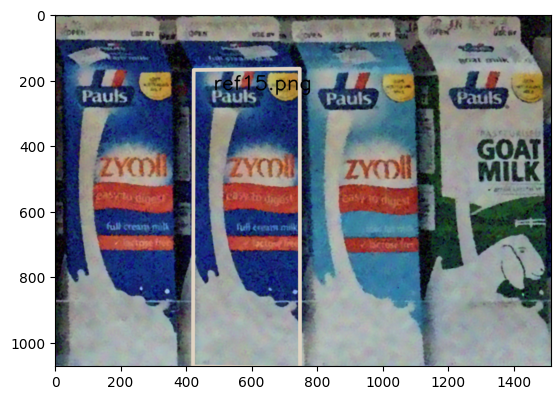

3
109
6
0
3
11
4
3
4
6
2
5
1
Scene image scene7.png
   Item found ref16.png : [ position: (794.942, 460.759), width: 215.9759979248047 px, height: 599.968017578125 px ]


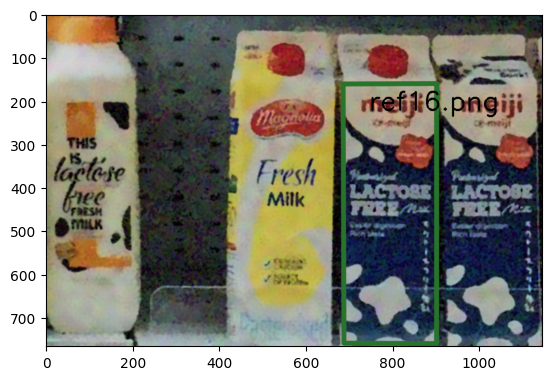

1
9
86
16
11
4
3
3
87
80
2
30
20
Scene image scene8.png
   Item found ref17.png : [ position: (648.679, 568.34), width: 325.7279968261719 px, height: 854.3090209960938 px ]
   Item found ref23.png : [ position: (988.535, 566.108), width: 321.0589904785156 px, height: 869.301025390625 px ]
   Item found ref24.png : [ position: (1337.46, 579.619), width: 325.5679931640625 px, height: 853.5130004882812 px ]
   Item found ref26.png : [ position: (258.792, 561.46), width: 388.1369934082031 px, height: 804.6079711914062 px ]


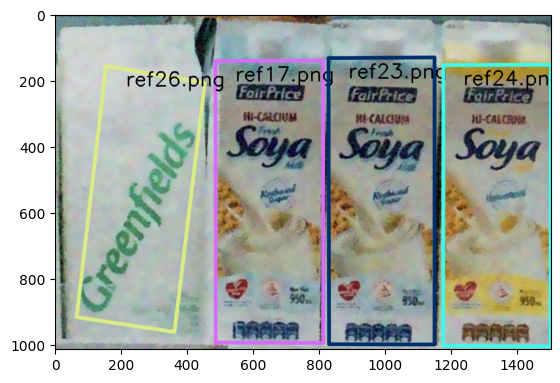

4
16
7
0
40
17
4
3
8
6
2
2
1
Scene image scene9.png
   Item found ref19.png : [ position: (845.26, 357.344), width: 236.06199645996094 px, height: 608.1669921875 px ]


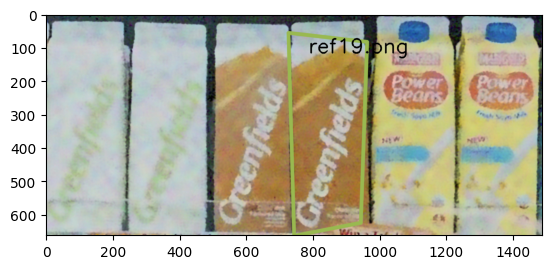

3
9
6
1
1
20
29
29
3
2
4
3
1
Scene image scene10.png
   Item found ref21.png : [ position: (993.943, 562.0), width: 275.18499755859375 px, height: 800.9959716796875 px ]
   Item found ref22.png : [ position: (1526.668, 534.653), width: 249.66200256347656 px, height: 708.4030151367188 px ]


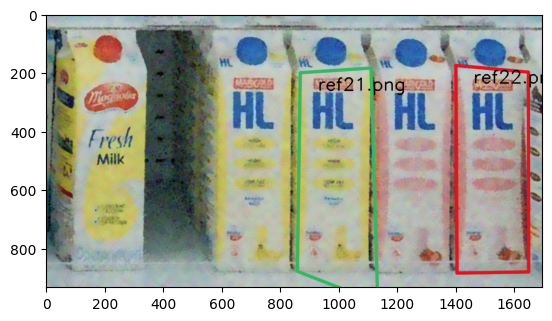

1
3
36
0
4
2
2
1
26
22
30
0
0
Scene image scene11.png
   Item found ref25.png : [ position: (1143.447, 370.339), width: 185.61099243164062 px, height: 480.4880065917969 px ]
   Item found ref17.png : [ position: (166.996, 361.225), width: 183.47000122070312 px, height: 482.8169860839844 px ]


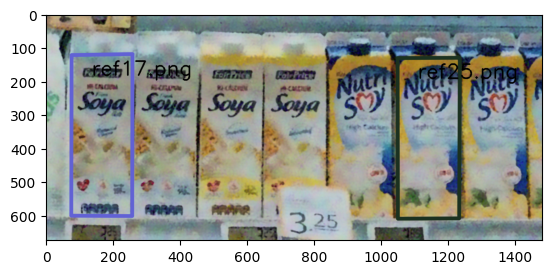

5
10
5
22
0
1
4
1
6
3
2
38
36
Scene image scene12.png
   Item found ref26.png : [ position: (134.98, 382.327), width: 244.55299377441406 px, height: 596.9580078125 px ]


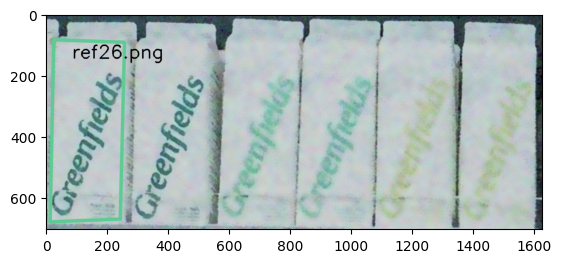

In [39]:
min_match_count = 25
find_items_in_scene_images(min_match_count, track_B_reference_images, track_B_scene_images, lambda_matcher, lambda_homography)